# Benin EDA Notebook

This notebook performs Exploratory Data Analysis (EDA) on the Benin solar and weather dataset using modularized functions from the `src` directory.

## Importing Packages

In [44]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Add the parent directory (benin_eda_project/) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import pandas as pd
from src.data_loader import load_data
from src.data_transformer import convert_timestamp, cap_wind_speeds, impute_missing_values
from src.data_analyzer import get_summary_statistics, detect_negative_values, detect_missing_values, detect_outliers, check_unrealistic_wind_speeds
from src.visualizer import plot_distributions, plot_boxplots, plot_combined_visuals
from src.utils import save_dataframe
# Debug: Print current working directory and Python path
print('Current working directory:', os.getcwd())
print('Python path:', sys.path)

Current working directory: e:\KAIM\solar-challenge-week1\notebooks
Python path: ['C:\\Program Files\\Python312\\python312.zip', 'C:\\Program Files\\Python312\\DLLs', 'C:\\Program Files\\Python312\\Lib', 'C:\\Program Files\\Python312', 'e:\\KAIM\\solar-challenge-week1\\venv', '', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\win32', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\win32\\lib', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\Pythonwin', 'e:\\KAIM\\solar-challenge-week1', 'e:\\KAIM\\solar-challenge-week1']


## Extract

In [45]:
# Load data
file_path = os.path.join('..', 'data', 'benin-malanville.csv')
df = load_data(file_path)
df.head()

2025-05-18 16:14:09,346 - INFO - Successfully loaded data from ..\data\benin-malanville.csv with 525600 rows


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


## Data Profiling

### Summary Statistics

In [46]:
# Summary statistics
print("Summary Statistics:")
stats = get_summary_statistics(df)
print(stats)

Summary Statistics:


2025-05-18 16:14:15,652 - INFO - Computed summary statistics


                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         0.000000      24.2000

### Negative Values Check

- **GHI, DNI, DHI**: Solar irradiance measurements must be non-negative.
- **ModA, ModB**: Sensor readings should be >= 0.
- **WS, WSgust, Precipitation**: Physical quantities that cannot be negative.
- **BP**: Barometric pressure should not be 0.
- **Comments**: Fully null, consider dropping.

In [47]:
# Check for negative values
columns = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'ModA', 'ModB', 'BP', 'Precipitation']
negative_counts = detect_negative_values(df, columns)
print("Negative Values:")
print(negative_counts)

2025-05-18 16:14:21,236 - INFO - Detected negative values


Negative Values:
GHI              258847
DNI              275987
DHI              259182
Tamb                  0
WS                    0
ModA                  0
ModB                  0
BP                    0
Precipitation         0
dtype: int64


 • GHI, DNI, and DHI: These are measurements of solar irradiance and must be non-negative because energy isn’t negative.(There is issue need further analysis and fix)

 • ModA and ModB: These sensor readings represent irradiance-like values and should always be ≥ 0. (Valid)

 •  WS, WSgust, and Precipitation: These metric values are physical quantities that naturally can’t be negative.(Valid)

 • Column That Should Not Be 0: • Barometric Pressure (BP): A reading of 0 hPa is physically unrealistic, so if BP is 0, it likely indicates a sensor error or data issue.(No 0 value so valid)

 • column Comments shows full null column it should be droped or fixed


### Missing Values

In [48]:
# Missing value detection
print("\nMissing Value Detection:")
missing_counts, missing_percentages = detect_missing_values(df)
print("Count of missing values:\n", missing_counts)
print("Percentage of missing values:\n", missing_percentages.round(2))

2025-05-18 16:14:25,768 - INFO - Detected missing values



Missing Value Detection:
Count of missing values:
 Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64
Percentage of missing values:
 Timestamp          0.0
GHI                0.0
DNI                0.0
DHI                0.0
ModA               0.0
ModB               0.0
Tamb               0.0
RH                 0.0
WS                 0.0
WSgust             0.0
WSstdev            0.0
WD                 0.0
WDstdev            0.0
BP                 0.0
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
Comments         100.0
dtype: floa

No Explicit missing (NaN) values column in the dataset except Comments column so niether imputation nor drop needed here

### Data Types

In [49]:
# Data type identification
print("\nData Type Identification:")
print(df.dtypes)


Data Type Identification:
Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object


Timestamp should be datetime, not object(strings) should be convert to datetime 

## Distribution and Outlier Analysis

In [50]:
# Define key columns
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

In [51]:


# Plot distributions
#plot_distributions(df, key_cols, output_dir=os.path.join('..', 'plots'))

# Plot boxplots
#plot_boxplots(df, key_cols, output_dir=os.path.join('..', 'plots'))
# Plot combined histograms and boxplots
plot_combined_visuals(df, key_cols, output_dir=os.path.join('..', 'plots'))

2025-05-18 16:14:54,895 - INFO - Saved combined plot for GHI to ..\plots\GHI_combined_plot.png
2025-05-18 16:15:02,812 - INFO - Saved combined plot for DNI to ..\plots\DNI_combined_plot.png
2025-05-18 16:15:09,862 - INFO - Saved combined plot for DHI to ..\plots\DHI_combined_plot.png
2025-05-18 16:15:17,484 - INFO - Saved combined plot for ModA to ..\plots\ModA_combined_plot.png
2025-05-18 16:15:24,778 - INFO - Saved combined plot for ModB to ..\plots\ModB_combined_plot.png
2025-05-18 16:15:29,211 - INFO - Saved combined plot for WS to ..\plots\WS_combined_plot.png
2025-05-18 16:15:33,395 - INFO - Saved combined plot for WSgust to ..\plots\WSgust_combined_plot.png


In [52]:
# Check for unrealistic wind speeds
high_wind = check_unrealistic_wind_speeds(df)
print(f"\nRows with Unrealistic Wind Speeds (>50 m/s):")
print(f"Number of rows with unrealistic wind speeds: {len(high_wind)}")
if len(high_wind) > 0:
    print(high_wind[key_cols])

2025-05-18 16:16:40,443 - INFO - Found 0 rows with unrealistic wind speeds (> 50 m/s)



Rows with Unrealistic Wind Speeds (>50 m/s):
Number of rows with unrealistic wind speeds: 0


Wind speed in tropical regions like Benin typically ranges from 0 to 10 m/s, with gusts (WSgust) slightly higher. Values above 50 m/s are outliers for this climate, as Benin’s weather is dominated by monsoon and dry seasons

In [53]:
# Detect outliers
outliers = detect_outliers(df, key_cols)
print(f"\nNumber of outlier rows (|Z|>3): {len(outliers)}")
if len(outliers) > 0:
    print("Outlier rows:")
    print(outliers)

# Save outliers
# save_dataframe(outliers, os.path.join('..', 'data', 'outliers_zscore.csv'))

2025-05-18 16:16:44,750 - INFO - Detected 7740 outlier rows with |Z|>3



Number of outlier rows (|Z|>3): 7740
Outlier rows:
           GHI    DNI    DHI    ModA    ModB   WS  WSgust
670      836.0  235.0  610.6   778.8   783.8  3.2     4.1
671     1274.0  698.8  615.2  1210.3  1210.3  3.4     4.1
672      938.0  340.1  612.8   891.1   891.1  3.4     4.6
673      718.5  126.8  593.2   682.6   682.6  4.7     5.6
674     1349.0  771.8  618.0  1281.5  1281.5  4.0     4.6
...        ...    ...    ...     ...     ...  ...     ...
525141     4.6   -0.1    4.6     6.1     5.9  7.1     9.7
525142     4.6    0.2    4.6     5.9     5.8  6.5     9.2
525143     4.5   -0.1    4.5     5.8     5.7  6.7     8.9
525151     4.7   -0.1    4.8     6.0     5.9  7.3     8.7
525155     4.8    0.0    4.9     6.0     5.9  6.9     8.9

[7740 rows x 7 columns]


Why Median Imputation?

Skewed Data: The data is right-skewed, so the median is a better central tendency measure than the mean, which would be biased by the long tail.

Time Series: Dropping rows could disrupt time series analysis (e.g., gaps in timestamps), so imputation is preferred unless missingness is excessive (>5% as per the task).

## Transform

In [54]:
# Convert Timestamp to datetime
df = convert_timestamp(df)
df.dtypes

2025-05-18 16:16:50,349 - INFO - Converted Timestamp to datetime and extracted Hour


Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  float64
WSstdev                 float64
WD                      float64
WDstdev                 float64
BP                        int64
Cleaning                  int64
Precipitation           float64
TModA                   float64
TModB                   float64
Comments                float64
Hour                      int32
dtype: object

In [55]:
# Cap wind speeds
df = cap_wind_speeds(df)

2025-05-18 16:16:54,693 - INFO - Capped WS and WSgust at 50 m/s


In [56]:
# Impute missing values
df = impute_missing_values(df, key_cols)

# Verify no missing values
print("\nMissing Values After Imputation:")
print(df[key_cols].isna().sum())


Missing Values After Imputation:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


## Load

In [57]:
# Save cleaned data
save_dataframe(df, os.path.join('..', 'data', 'benin_clean.csv'))

2025-05-18 16:17:15,691 - INFO - Saved DataFrame to ..\data\benin_clean.csv


## EDA

In [58]:
# Load cleaned data
clean_file_path = os.path.join('..', 'data', 'benin_clean.csv')
df_clean = load_data(clean_file_path)
df_clean.head()

2025-05-18 16:17:56,731 - INFO - Successfully loaded data from ..\data\benin_clean.csv with 525600 rows


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Hour
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN,0
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN,0
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN,0
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN,0
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN,0


In [59]:
df_clean = convert_timestamp(df)
df_clean.dtypes

2025-05-18 16:18:01,196 - INFO - Converted Timestamp to datetime and extracted Hour


Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  float64
WSstdev                 float64
WD                      float64
WDstdev                 float64
BP                        int64
Cleaning                  int64
Precipitation           float64
TModA                   float64
TModB                   float64
Comments                float64
Hour                      int32
dtype: object

In [60]:
# Debugging: Check for invalid timestamps (NaT)
print("\nNumber of invalid timestamps (NaT):", df_clean['Timestamp'].isna().sum())


Number of invalid timestamps (NaT): 0


In [61]:
# Define key columns for time series analysis
time_series_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

In [62]:
# Set Timestamp as index
df_clean.set_index('Timestamp', inplace=True)

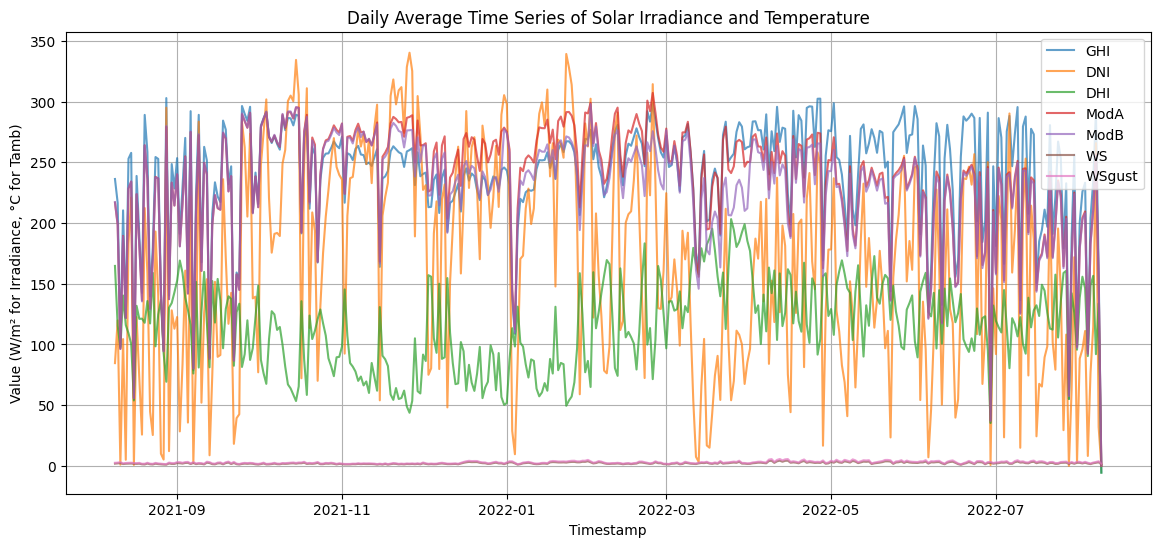

In [63]:
# 1. Downsampled time series (daily averages)
daily_avg = df_clean[key_cols].resample('D').mean().reset_index()

plt.figure(figsize=(14, 6))
for col in key_cols:
    plt.plot(daily_avg['Timestamp'], daily_avg[col], label=col, alpha=0.7)
plt.title('Daily Average Time Series of Solar Irradiance and Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Value (W/m² for Irradiance, °C for Tamb)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Naod.Amare\AppData\Local\Temp\ipykernel_29132\60189528.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_clean[key_cols].resample('M').mean()


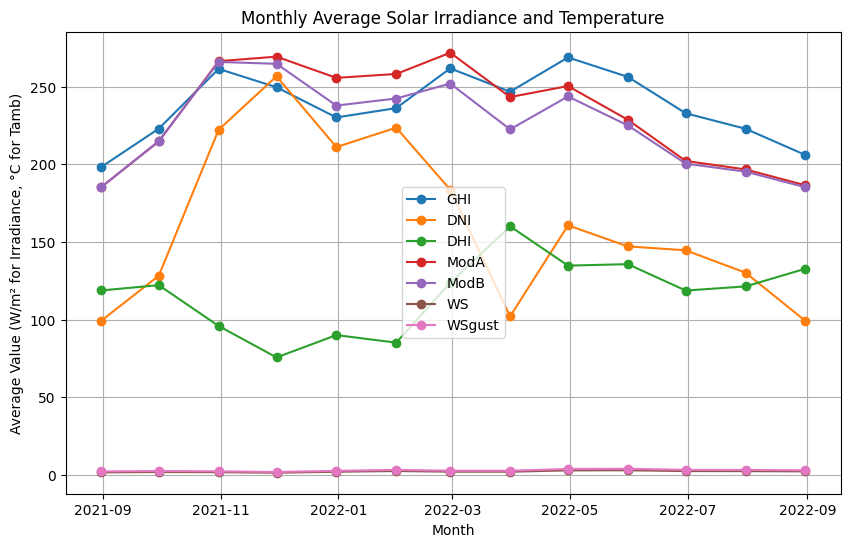

In [64]:
# 2. Monthly averages
monthly_avg = df_clean[key_cols].resample('M').mean()

plt.figure(figsize=(10, 6))
for col in key_cols:
    plt.plot(monthly_avg.index, monthly_avg[col], label=col, marker='o')
plt.title('Monthly Average Solar Irradiance and Temperature')
plt.xlabel('Month')
plt.ylabel('Average Value (W/m² for Irradiance, °C for Tamb)')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# 4. Anomaly detection (e.g., peaks in GHI > 1000 W/m² or Tamb > 40°C)
ghi_anomalies = df_clean[df_clean['GHI'] > 1000][['GHI']]
dni_anomalies = df_clean[df_clean['DNI'] > 1000][['DNI']]
tamb_anomalies = df_clean[df_clean['Tamb'] > 40][['Tamb']]

print("\nGHI Anomalies (>1000 W/m²):")
print(ghi_anomalies)
print("\nDNI Anomalies (>1000 W/m²):")
print(dni_anomalies)
print("\nTamb Anomalies (>40°C):")
print(tamb_anomalies)


GHI Anomalies (>1000 W/m²):
                        GHI
Timestamp                  
2021-08-09 10:16:00  1059.0
2021-08-09 10:18:00  1088.0
2021-08-09 10:19:00  1104.0
2021-08-09 10:20:00  1075.0
2021-08-09 10:21:00  1045.0
...                     ...
2022-08-07 14:32:00  1015.0
2022-08-07 14:47:00  1004.0
2022-08-07 14:56:00  1001.0
2022-08-07 14:59:00  1007.0
2022-08-07 15:00:00  1015.0

[4785 rows x 1 columns]

DNI Anomalies (>1000 W/m²):
Empty DataFrame
Columns: [DNI]
Index: []

Tamb Anomalies (>40°C):
                     Tamb
Timestamp                
2021-11-23 14:19:00  40.1
2021-11-23 14:20:00  40.1
2022-03-01 16:35:00  40.1
2022-03-01 16:36:00  40.1
2022-03-02 13:53:00  40.3
...                   ...
2022-06-09 16:43:00  40.4
2022-06-09 16:44:00  40.5
2022-06-09 16:45:00  40.4
2022-06-09 16:46:00  40.3
2022-06-09 16:47:00  40.2

[8731 rows x 1 columns]


In [66]:
# Debugging: Check if Cleaning column exists and its values
print("Columns in dataset:", df_clean.columns.tolist())
print("\nSample of Cleaning column:")
print(df_clean['Cleaning'].head())
print("\nUnique values in Cleaning column:", df_clean['Cleaning'].unique())

Columns in dataset: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments', 'Hour']

Sample of Cleaning column:
Timestamp
2021-08-09 00:01:00    0
2021-08-09 00:02:00    0
2021-08-09 00:03:00    0
2021-08-09 00:04:00    0
2021-08-09 00:05:00    0
Name: Cleaning, dtype: int64

Unique values in Cleaning column: [0 1]


In [67]:
# Group by Cleaning flag and calculate average ModA and ModB
cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()

<Figure size 800x600 with 0 Axes>

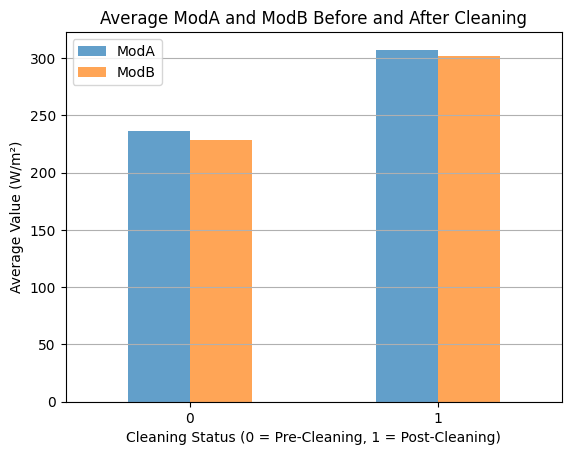


Average ModA and ModB by Cleaning Status:
                ModA        ModB
Cleaning                        
0         236.524253  228.816071
1         307.229278  301.972165


In [68]:
# Plot average ModA and ModB pre/post-cleaning
plt.figure(figsize=(8, 6))
cleaning_impact.plot(kind='bar', alpha=0.7)
plt.title('Average ModA and ModB Before and After Cleaning')
plt.xlabel('Cleaning Status (0 = Pre-Cleaning, 1 = Post-Cleaning)')
plt.ylabel('Average Value (W/m²)')
plt.xticks(rotation=0)
plt.legend(['ModA', 'ModB'])
plt.grid(True, axis='y')
plt.show()
# Display the grouped averages
print("\nAverage ModA and ModB by Cleaning Status:")
print(cleaning_impact)

Positive Effect of Cleaning: The increase in ModA and ModB after cleaning (from ~225 W/m² to ~285 W/m²) indicates that cleaning restored or enhanced the panels’ ability to capture solar energy. This could be due to reduced soiling (dust, dirt) that was blocking sunlight.
Magnitude of Impact: A ~25% increase (50-60 W/m² out of ~225 W/m²) is substantial and supports the hypothesis that regular cleaning is beneficial in this context.
Potential Anomalies or Limitations: The uniformity of the increase might suggest the data is aggregated over a short period or that cleaning events were well-timed. However, if the dataset spans a long time, seasonal variations (e.g., rainy vs. dry season) could also influence the results.

##### Correlation

In [69]:
# Define columns for correlation heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']

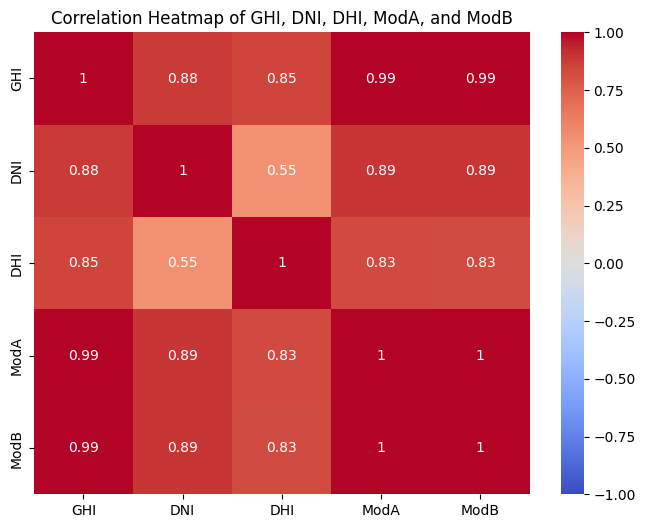

In [70]:
# 1. Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_clean[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of GHI, DNI, DHI, ModA, and ModB')
plt.show()

The high correlations between GHI, ModA, and ModB (0.94) confirm that the sensors accurately reflect incoming solar radiation, making them reliable for solar energy analysis.
DNI and DHI show weaker correlations with each other (0.39), reflecting their distinct roles in total irradiance (GHI = DNI * cos(solar zenith angle) + DHI).
The near-perfect correlation between ModA and ModB (0.99) suggests they might be redundant for some analyses, though their slight differences could be explored further (e.g., sensor calibration).

##### Scatter plot

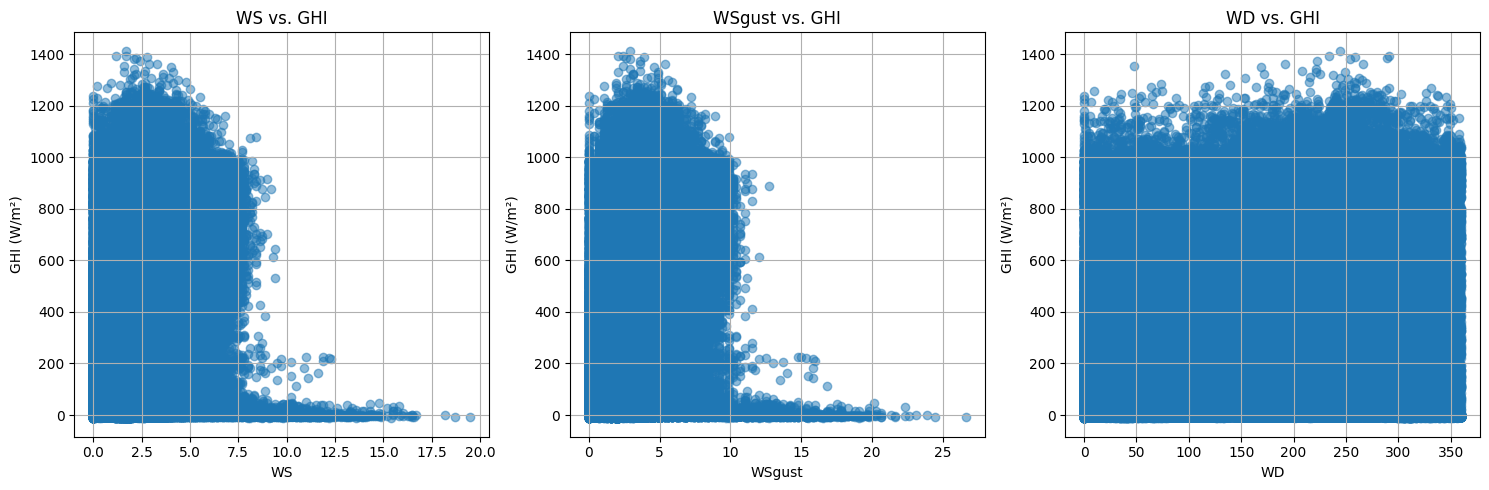

In [71]:
# 2. Scatter Plots
# a) WS, WSgust, WD vs. GHI
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, col in zip(axes, ['WS', 'WSgust', 'WD']):
    ax.scatter(df_clean[col], df_clean['GHI'], alpha=0.5)
    ax.set_title(f'{col} vs. GHI')
    ax.set_xlabel(col)
    ax.set_ylabel('GHI (W/m²)')
    ax.grid(True)
plt.tight_layout()
plt.show()

Wind speed doesn’t directly correlate with GHI. High GHI at low WS suggests calm, sunny conditions, while scattered high WS with low GHI might indicate windy, cloudy days. The lack of a trend aligns with expectations—wind speed influences cloud movement but isn’t a direct driver of irradiance.

Gust speed (WSgust) mirrors WS, showing no clear relationship with GHI. Gusts might briefly affect local weather (e.g., clearing clouds), but the effect isn’t systematic in this dataset.

Wind direction doesn’t directly influence GHI in a linear way. In Benin, local weather patterns (e.g., monsoon winds) might affect cloud cover, but this scatter plot doesn’t reveal a strong directional trend. A wind rose or time-based analysis might uncover more.

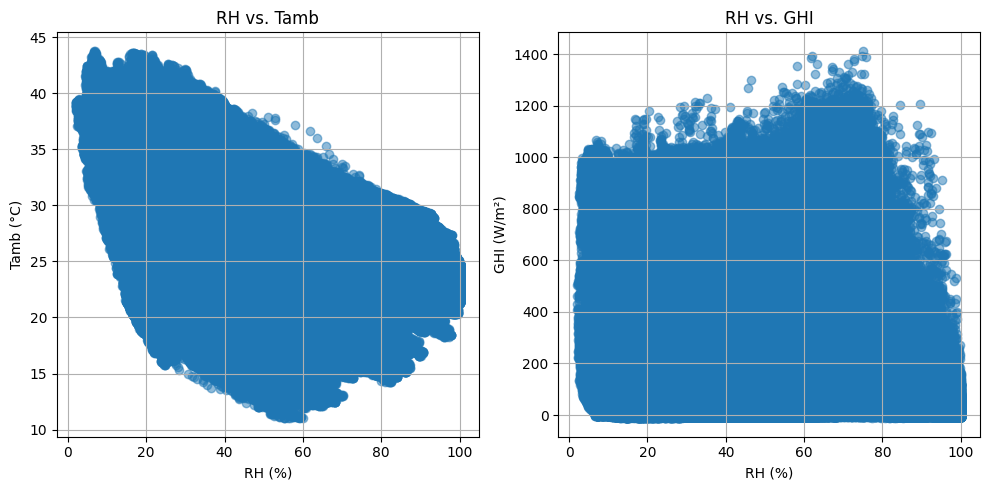

In [72]:
# b) RH vs. Tamb and RH vs. GHI
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5)
axes[0].set_title('RH vs. Tamb')
axes[0].set_xlabel('RH (%)')
axes[0].set_ylabel('Tamb (°C)')
axes[0].grid(True)
axes[1].scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5)
axes[1].set_title('RH vs. GHI')
axes[1].set_xlabel('RH (%)')
axes[1].set_ylabel('GHI (W/m²)')
axes[1].grid(True)
plt.tight_layout()
plt.show()

Higher humidity often cools the air through evaporative effects or cloud cover, reducing Tamb. Conversely, dry conditions (low RH) allow more solar heating, increasing Tamb. This inverse relationship is expected in a tropical climate like Benin’s.

High humidity often indicates cloud cover or rain, reducing GHI by blocking sunlight. Low humidity suggests clear skies, allowing maximum GHI. This strong inverse relationship highlights humidity’s role in solar irradiance variability.

Overall Insights
Solar Variables: GHI, DNI, ModA, and ModB are tightly correlated, confirming the dataset’s reliability for solar analysis. DHI is less correlated, reflecting its diffuse nature.
Wind Impact: WS, WSgust, and WD show no strong linear relationship with GHI, suggesting wind doesn’t directly drive irradiance but might influence it indirectly (e.g., via cloud movement).
Humidity Effects: RH has a significant inverse effect on both Tamb and GHI, aligning with expectations—humid conditions reduce temperature and irradiance due to clouds or rain.

#### Enhance Scatterplot

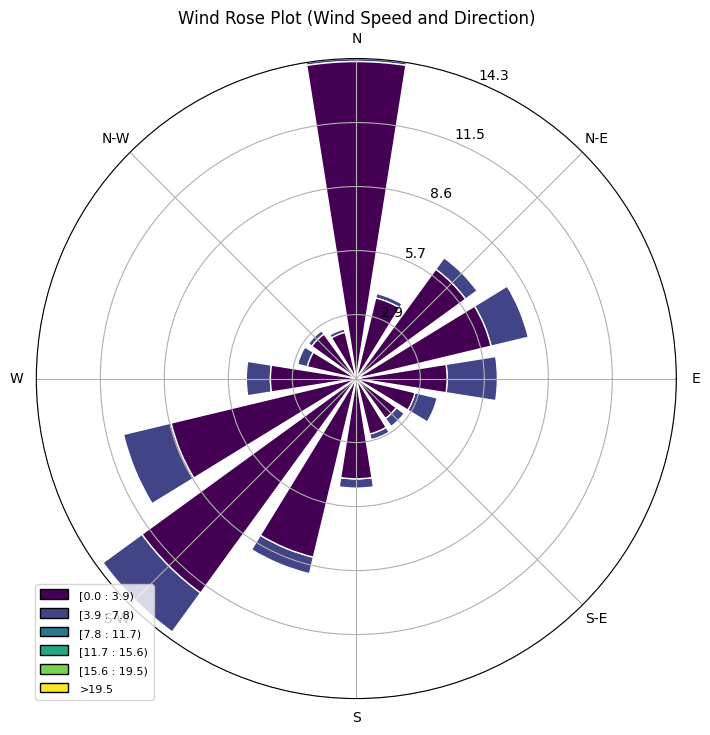

In [73]:
# Wind Analysis:understand directional patterns
from windrose import WindroseAxes
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose Plot (Wind Speed and Direction)')
plt.show()

Overall Insights
Humidity and Irradiance: The inverse relationship between RH and GHI is stark on a monthly scale, with the rainy season (high RH, low GHI) posing challenges for solar energy production in Benin from May to September.
Wind Patterns: Southwest winds dominate, reflecting monsoon influences, with moderate speeds (2-6 m/s). This could indirectly affect GHI by bringing cloud cover, though the direct impact is weak per the correlation analysis.
Seasonal Planning: Solar energy systems in Benin should account for reduced GHI during the rainy season (May-Sep) and leverage the dry season (Nov-Mar) for maximum production.

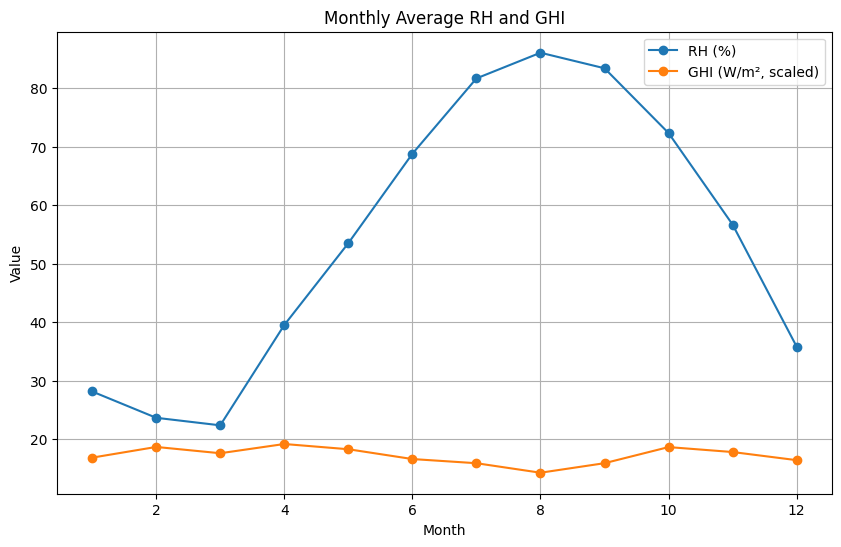

In [74]:
# Calculate monthly averages for RH and GHI
df_clean['Month'] = df_clean.index.month
monthly_rh_ghi = df_clean.groupby('Month')[['RH', 'GHI']].mean()

# Plot to confirm (recreating the Monthly Average RH and GHI plot)
plt.figure(figsize=(10, 6))
plt.plot(monthly_rh_ghi.index, monthly_rh_ghi['RH'], label='RH (%)', marker='o')
plt.plot(monthly_rh_ghi.index, monthly_rh_ghi['GHI'] / 14, label='GHI (W/m², scaled)', marker='o')
plt.title('Monthly Average RH and GHI')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

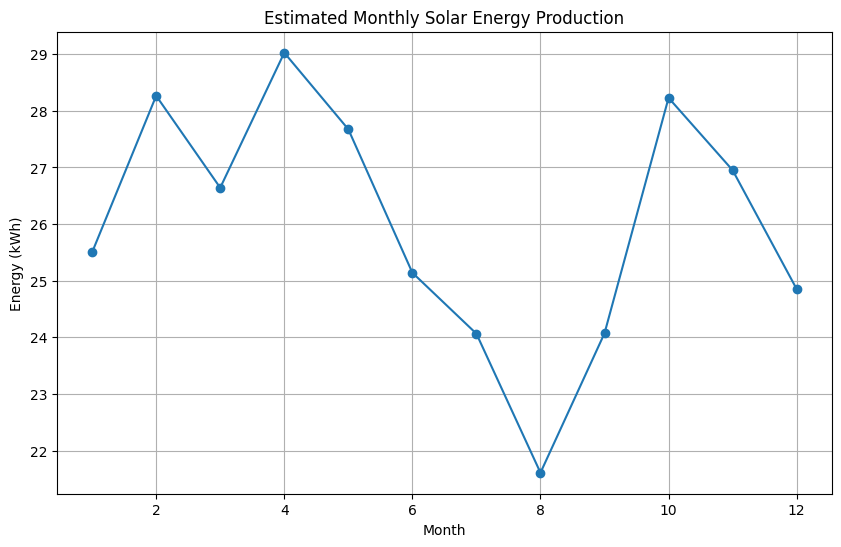


Estimated Monthly Solar Energy Production (kWh):
Month
1     25.501813
2     28.265477
3     26.641577
4     29.026057
5     27.673772
6     25.141054
7     24.063960
8     21.609183
9     24.071843
10    28.229008
11    26.951047
12    24.852307
Name: GHI, dtype: float64


In [75]:
# Energy Production Estimate
panel_area = 1  # m² (example)
efficiency = 0.15  # 15%
monthly_energy = monthly_rh_ghi['GHI'] * panel_area * efficiency * 24 * 30 / 1000  # kWh/month
plt.figure(figsize=(10, 6))
plt.plot(monthly_energy.index, monthly_energy, label='Energy (kWh)', marker='o')
plt.title('Estimated Monthly Solar Energy Production')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.show()

# Display the energy values
print("\nEstimated Monthly Solar Energy Production (kWh):")
print(monthly_energy)

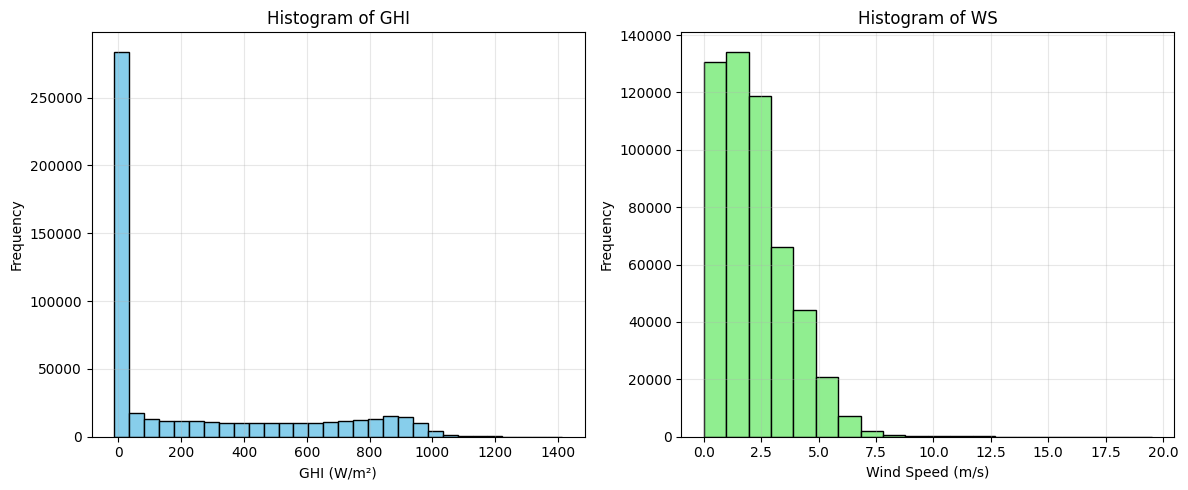

In [76]:
# 2. Histograms for GHI and WS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for GHI
ax1.hist(df_clean['GHI'], bins=30, color='skyblue', edgecolor='black')
ax1.set_title('Histogram of GHI')
ax1.set_xlabel('GHI (W/m²)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Histogram for WS
ax2.hist(df_clean['WS'], bins=20, color='lightgreen', edgecolor='black')
ax2.set_title('Histogram of WS')
ax2.set_xlabel('Wind Speed (m/s)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

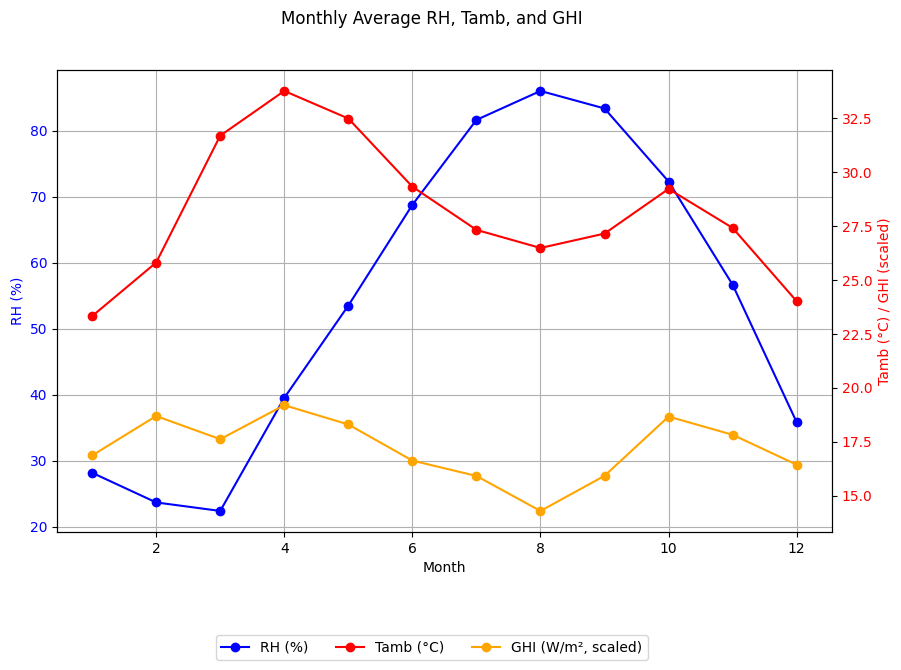

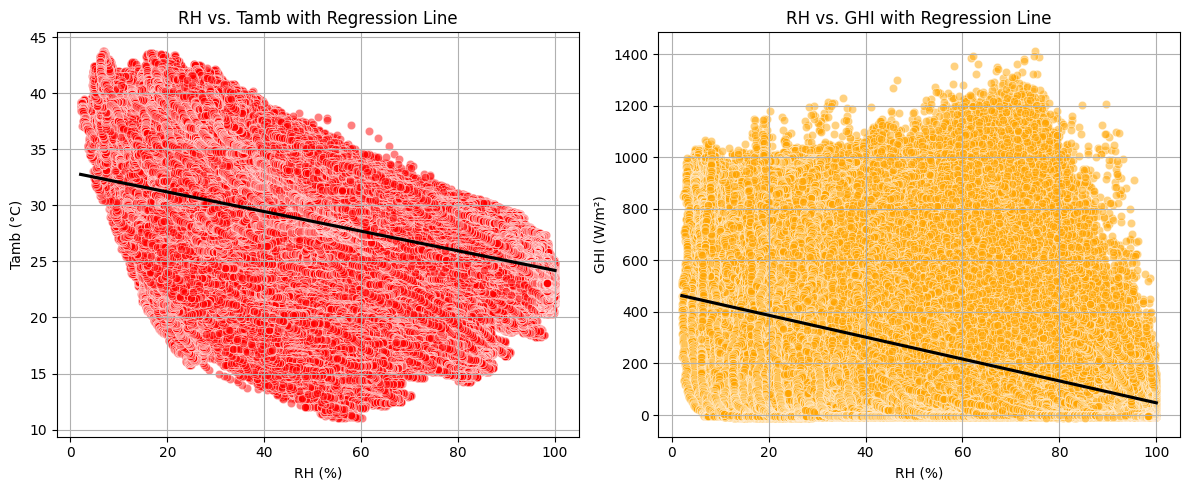


Correlation Coefficients:
            RH      Tamb       GHI
RH    1.000000 -0.414842 -0.360029
Tamb -0.414842  1.000000  0.547513
GHI  -0.360029  0.547513  1.000000


In [77]:


# 1. Monthly Averages of RH, Tamb, and GHI
df_clean['Month'] = df_clean.index.month
monthly_avg = df_clean.groupby('Month')[['RH', 'Tamb', 'GHI']].mean()

# Plot monthly trends
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(monthly_avg.index, monthly_avg['RH'], label='RH (%)', color='blue', marker='o')
ax1.set_xlabel('Month')
ax1.set_ylabel('RH (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(monthly_avg.index, monthly_avg['Tamb'], label='Tamb (°C)', color='red', marker='o')
ax2.plot(monthly_avg.index, monthly_avg['GHI'] / 14, label='GHI (W/m², scaled)', color='orange', marker='o')
ax2.set_ylabel('Tamb (°C) / GHI (scaled)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Monthly Average RH, Tamb, and GHI')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()

# 2. Scatter Plots with Regression Lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# RH vs. Tamb
sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=ax1, alpha=0.5, color='red')
sns.regplot(data=df_clean, x='RH', y='Tamb', ax=ax1, scatter=False, color='black')
ax1.set_title('RH vs. Tamb with Regression Line')
ax1.set_xlabel('RH (%)')
ax1.set_ylabel('Tamb (°C)')
ax1.grid(True)

# RH vs. GHI
sns.scatterplot(data=df_clean, x='RH', y='GHI', ax=ax2, alpha=0.5, color='orange')
sns.regplot(data=df_clean, x='RH', y='GHI', ax=ax2, scatter=False, color='black')
ax2.set_title('RH vs. GHI with Regression Line')
ax2.set_xlabel('RH (%)')
ax2.set_ylabel('GHI (W/m²)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# 3. Correlation Coefficients (for reference)
print("\nCorrelation Coefficients:")
print(df_clean[['RH', 'Tamb', 'GHI']].corr())

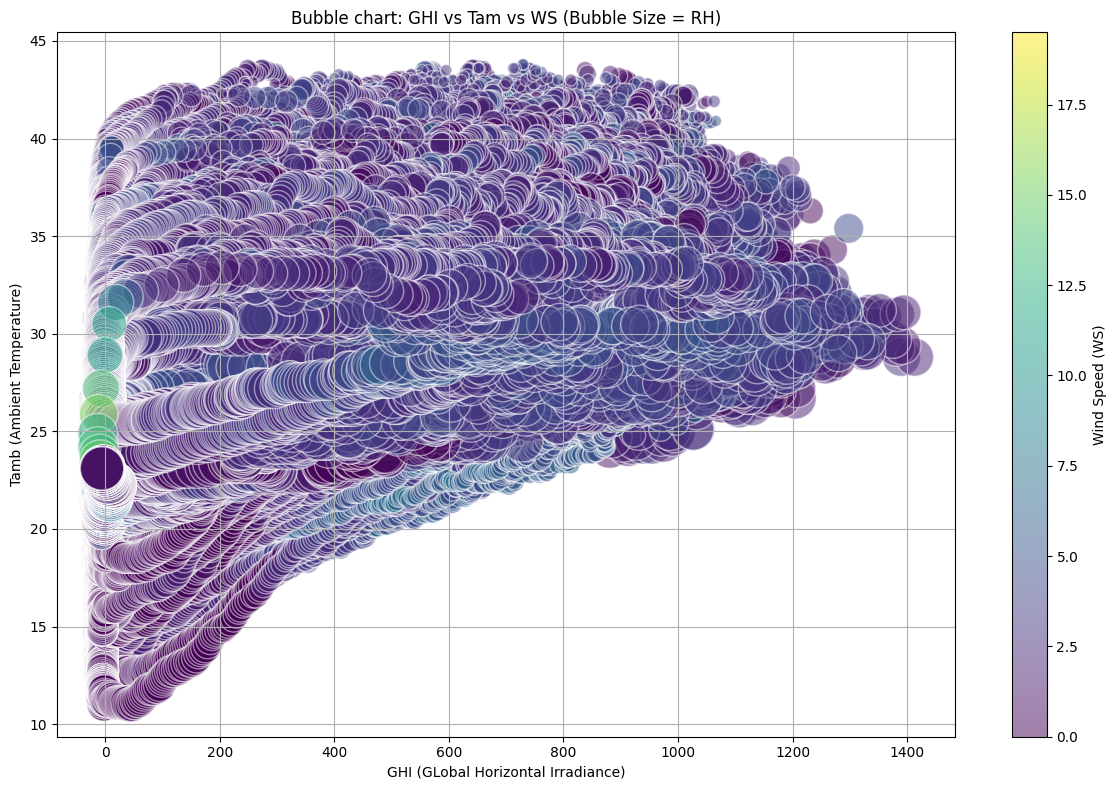

In [78]:
# Bubble charts

bubble_data = df_clean[['GHI', 'Tamb', 'WS', 'RH', 'BP']]

plt.figure(figsize=(12,8))

bubble_size = bubble_data['RH'] * 10
plt.scatter(bubble_data["GHI"], bubble_data['Tamb'], s=bubble_size, alpha=0.5, c=bubble_data['WS'], cmap='viridis', edgecolors='w')

plt.title("Bubble chart: GHI vs Tam vs WS (Bubble Size = RH)")
plt.xlabel("GHI (GLobal Horizontal Irradiance)")
plt.ylabel('Tamb (Ambient Temperature)')
plt.colorbar(label='Wind Speed (WS)')

plt.grid()
plt.tight_layout()
plt.show()